In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark import StorageLevel
import datetime
from datetime import datetime, date, timedelta
from pyspark.sql.functions import col, collect_list, udf, lower, from_json, to_timestamp, substring, date_add, unix_timestamp, hour
from pyspark.sql.functions import max as ps_max
from pyspark.sql.functions import sum as ps_sum
from pyspark.sql.functions import count as ps_count
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pymssql
from pyspark.sql.types import StructField, StructType, IntegerType, ArrayType, StringType, TimestampType

from pymongo import MongoClient
import numpy as np
import pandas as pd
from tqdm import tqdm

import json
import os

import traceback

from datetime import datetime
from bson.objectid import ObjectId

In [2]:
class config:
    folder_save_json = r"file_of_phimbo_boxmobilesmattv"

In [3]:
def get_spark_session():    
    spark = SparkSession.builder\
                        .master('yarn')\
                        .config('spark.submit.deployMode', 'client')\
                        .config('spark.driver.memory', '4g')\
                        .config('spark.driver.cores', '4')\
                        .config('spark.executor.memory', '4g')\
                        .config('spark.executor.cores', '4')\
                        .config('spark.dynamicAllocation.initialExecutors', '4')\
                        .config('spark.local.dir','/mnt/big-data/ViVH6_52/review_code_pyspark/evaluate_top_10/fd_log_draft1_evaluate_top_10')\
                        .appName('etl_testing_top10_vivh6_52_phimbo_boxmobilesmattv').getOrCreate()
    spark.sql("set spark.sql.caseSensitive=true")
    return spark

spark = get_spark_session()

Picked up JAVA_TOOL_OPTIONS: -Dhttp.proxyHost=210.245.31.15 -Dhttp.proxyPort=80 -Dhttps.proxyHost=210.245.31.15 -Dhttps.proxyPort=80
Picked up JAVA_TOOL_OPTIONS: -Dhttp.proxyHost=210.245.31.15 -Dhttp.proxyPort=80 -Dhttps.proxyHost=210.245.31.15 -Dhttps.proxyPort=80
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023-01-30 14:26:44,630 WARN spark.SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
2023-01-30 14:27:14,233 WARN util.Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 33100. Attempting port 33101.
2023-01-30 14:27:14,238 WARN util.Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 33101. Attempting port 33102.
2023-01-30 14:27:14,241 WARN util.Utils: Service 'org.apache.spark.networ

In [4]:
device_ordering = ["mobile", "box", "smarttv"]

In [5]:
def read_json():
    with open(path_json) as json_file:
        data = json.load(json_file)
    return data
    
def write_json(path_json, data):
    with open(path_json, 'w', encoding='utf-8') as outfile:
        json.dump(data, outfile, ensure_ascii=False)

In [6]:
def get_ls_day_between(str_start_date, str_end_date):
    sy, sm, sd = list(map(int, str_start_date.split("-")))
    ey, em, ed = list(map(int, str_end_date.split("-")))

    start_date = date(sy, sm, sd)
    end_date = date(ey, em, ed)

    ls_day_between = []
    delta = end_date - start_date
    for i in range(delta.days + 1):
        day = start_date + timedelta(days=i)
        day = str(day).replace("-", "/")
        ls_day_between.append(day)
    return ls_day_between

In [7]:
ls_day = get_ls_day_between(str_start_date = "2022-12-01",
                            str_end_date = "2022-12-31")

ls_day = [e.replace("/", "-") for e in ls_day]
ls_day

['2022-12-01',
 '2022-12-02',
 '2022-12-03',
 '2022-12-04',
 '2022-12-05',
 '2022-12-06',
 '2022-12-07',
 '2022-12-08',
 '2022-12-09',
 '2022-12-10',
 '2022-12-11',
 '2022-12-12',
 '2022-12-13',
 '2022-12-14',
 '2022-12-15',
 '2022-12-16',
 '2022-12-17',
 '2022-12-18',
 '2022-12-19',
 '2022-12-20',
 '2022-12-21',
 '2022-12-22',
 '2022-12-23',
 '2022-12-24',
 '2022-12-25',
 '2022-12-26',
 '2022-12-27',
 '2022-12-28',
 '2022-12-29',
 '2022-12-30',
 '2022-12-31']

In [8]:
ls_days_of_week = [r"{}-{}".format(e, datetime.strptime(e, "%Y-%m-%d").strftime('%A')[:3]) for e in ls_day]
ls_days_of_week

['2022-12-01-Thu',
 '2022-12-02-Fri',
 '2022-12-03-Sat',
 '2022-12-04-Sun',
 '2022-12-05-Mon',
 '2022-12-06-Tue',
 '2022-12-07-Wed',
 '2022-12-08-Thu',
 '2022-12-09-Fri',
 '2022-12-10-Sat',
 '2022-12-11-Sun',
 '2022-12-12-Mon',
 '2022-12-13-Tue',
 '2022-12-14-Wed',
 '2022-12-15-Thu',
 '2022-12-16-Fri',
 '2022-12-17-Sat',
 '2022-12-18-Sun',
 '2022-12-19-Mon',
 '2022-12-20-Tue',
 '2022-12-21-Wed',
 '2022-12-22-Thu',
 '2022-12-23-Fri',
 '2022-12-24-Sat',
 '2022-12-25-Sun',
 '2022-12-26-Mon',
 '2022-12-27-Tue',
 '2022-12-28-Wed',
 '2022-12-29-Thu',
 '2022-12-30-Fri',
 '2022-12-31-Sat']

In [9]:
template_hdfs_mobile = r"hdfs://172.20.2.52:8020/ViVH6_52/analysis_round3/mobile/phimbophimleIPTV_{}"
path_hdfs_mobile = [template_hdfs_mobile.format(e) for e in ls_day]

template_hdfs_box = r"hdfs://172.20.2.52:8020/ViVH6_52/analysis_round3/box/phimbophimleIPTV_{}"
path_hdfs_box = [template_hdfs_box.format(e) for e in ls_day]

template_hdfs_smarttv = r"hdfs://172.20.2.52:8020/ViVH6_52/analysis_round3/smarttv/phimbophimleIPTV_{}"
path_hdfs_smarttv = [template_hdfs_smarttv.format(e) for e in ls_day]


print(path_hdfs_mobile)
print(path_hdfs_box)
print(path_hdfs_smarttv)


['hdfs://172.20.2.52:8020/ViVH6_52/analysis_round3/mobile/phimbophimleIPTV_2022-12-01', 'hdfs://172.20.2.52:8020/ViVH6_52/analysis_round3/mobile/phimbophimleIPTV_2022-12-02', 'hdfs://172.20.2.52:8020/ViVH6_52/analysis_round3/mobile/phimbophimleIPTV_2022-12-03', 'hdfs://172.20.2.52:8020/ViVH6_52/analysis_round3/mobile/phimbophimleIPTV_2022-12-04', 'hdfs://172.20.2.52:8020/ViVH6_52/analysis_round3/mobile/phimbophimleIPTV_2022-12-05', 'hdfs://172.20.2.52:8020/ViVH6_52/analysis_round3/mobile/phimbophimleIPTV_2022-12-06', 'hdfs://172.20.2.52:8020/ViVH6_52/analysis_round3/mobile/phimbophimleIPTV_2022-12-07', 'hdfs://172.20.2.52:8020/ViVH6_52/analysis_round3/mobile/phimbophimleIPTV_2022-12-08', 'hdfs://172.20.2.52:8020/ViVH6_52/analysis_round3/mobile/phimbophimleIPTV_2022-12-09', 'hdfs://172.20.2.52:8020/ViVH6_52/analysis_round3/mobile/phimbophimleIPTV_2022-12-10', 'hdfs://172.20.2.52:8020/ViVH6_52/analysis_round3/mobile/phimbophimleIPTV_2022-12-11', 'hdfs://172.20.2.52:8020/ViVH6_52/analysis

In [10]:
# _mobile

total_view_LogId111_mobile = 0
ls_view_LogId111_each_day_mobile = []

for day, path_hdfs_1_day_mobile in zip(ls_day, path_hdfs_mobile):
    df_mobile = spark.read.orc(path_hdfs_1_day_mobile)
    df_mobile = df_mobile.filter(lower(col('AppName')) == "phim bộ")
    df_count_mobile = df_mobile.count()
    ls_view_LogId111_each_day_mobile.append(df_count_mobile)
    total_view_LogId111_mobile += df_count_mobile
    print("Mobile:\t", day, ":\t", df_count_mobile)

print("total_view_LogId111_mobile:\t", total_view_LogId111_mobile)

# _box

total_view_LogId111_box = 0
ls_view_LogId111_each_day_box = []

for day, path_hdfs_1_day_box in zip(ls_day, path_hdfs_box):
    df_box = spark.read.orc(path_hdfs_1_day_box)
    df_box = df_box.filter(lower(col('AppName')) == "phim bộ")
    df_count_box = df_box.count()
    ls_view_LogId111_each_day_box.append(df_count_box)
    total_view_LogId111_box += df_count_box
    print("Box:\t", day, ":\t", df_count_box)

print("total_view_LogId111_box:\t", total_view_LogId111_box)

# _smarttv

total_view_LogId111_smarttv = 0
ls_view_LogId111_each_day_smarttv = []

for day, path_hdfs_1_day_smarttv in zip(ls_day, path_hdfs_smarttv):
    df_smarttv = spark.read.orc(path_hdfs_1_day_smarttv)
    df_smarttv = df_smarttv.filter(lower(col('AppName')) == "phim bộ")
    df_count_smarttv = df_smarttv.count()
    ls_view_LogId111_each_day_smarttv.append(df_count_smarttv)
    total_view_LogId111_smarttv += df_count_smarttv
    print("Smarttv:\t", day, ":\t", df_count_smarttv)

print("total_view_LogId111_smarttv:\t", total_view_LogId111_smarttv)

2023-01-30 14:27:47,532 WARN cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
2023-01-30 14:28:02,531 WARN cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


Mobile:	 2022-12-01 :	 32685


Mobile:	 2022-12-02 :	 32069
Mobile:	 2022-12-03 :	 35987
Mobile:	 2022-12-04 :	 38551
Mobile:	 2022-12-05 :	 32118
Mobile:	 2022-12-06 :	 32349
Mobile:	 2022-12-07 :	 32539
Mobile:	 2022-12-08 :	 28825
Mobile:	 2022-12-09 :	 33821
Mobile:	 2022-12-10 :	 35549
Mobile:	 2022-12-11 :	 38947
Mobile:	 2022-12-12 :	 29735
Mobile:	 2022-12-13 :	 30946
Mobile:	 2022-12-14 :	 31379
Mobile:	 2022-12-15 :	 30512
Mobile:	 2022-12-16 :	 30598
Mobile:	 2022-12-17 :	 33669


Mobile:	 2022-12-18 :	 36870
Mobile:	 2022-12-19 :	 32511
Mobile:	 2022-12-20 :	 28921
Mobile:	 2022-12-21 :	 31550
Mobile:	 2022-12-22 :	 30437
Mobile:	 2022-12-23 :	 27899
Mobile:	 2022-12-24 :	 27986
Mobile:	 2022-12-25 :	 30234
Mobile:	 2022-12-26 :	 26685
Mobile:	 2022-12-27 :	 33261
Mobile:	 2022-12-28 :	 34303
Mobile:	 2022-12-29 :	 35335
Mobile:	 2022-12-30 :	 34055
Mobile:	 2022-12-31 :	 35474
total_view_LogId111_mobile:	 1005800
Box:	 2022-12-01 :	 25826
Box:	 2022-12-02 :	 25257
Box:	 2022-12-03 :	 27849
Box:	 2022-12-04 :	 30032
Box:	 2022-12-05 :	 26306
Box:	 2022-12-06 :	 26189
Box:	 2022-12-07 :	 28302
Box:	 2022-12-08 :	 29282
Box:	 2022-12-09 :	 28598
Box:	 2022-12-10 :	 27177
Box:	 2022-12-11 :	 30427
Box:	 2022-12-12 :	 28720
Box:	 2022-12-13 :	 27490
Box:	 2022-12-14 :	 26045
Box:	 2022-12-15 :	 26482
Box:	 2022-12-16 :	 27345
Box:	 2022-12-17 :	 27977
Box:	 2022-12-18 :	 28017
Box:	 2022-12-19 :	 23867
Box:	 2022-12-20 :	 26105
Box:	 2022-12-21 :	 26099
Box:	 2022-

In [11]:
write_json(r"{}/{}.json".format(config.folder_save_json, "ls_view_LogId111_each_day_mobile"), ls_view_LogId111_each_day_mobile)
write_json(r"{}/{}.json".format(config.folder_save_json, "ls_view_LogId111_each_day_box"), ls_view_LogId111_each_day_box)
write_json(r"{}/{}.json".format(config.folder_save_json, "ls_view_LogId111_each_day_smarttv"), ls_view_LogId111_each_day_smarttv)

In [12]:
write_json(r"{}/{}.json".format(config.folder_save_json, "total_view_LogId111_mobile"), total_view_LogId111_mobile)
write_json(r"{}/{}.json".format(config.folder_save_json, "total_view_LogId111_box"), total_view_LogId111_box)
write_json(r"{}/{}.json".format(config.folder_save_json, "total_view_LogId111_smarttv"), total_view_LogId111_smarttv)

Text(0.5, 1.0, 'Số lượt xem phim bộ mỗi ngày trên mobile')

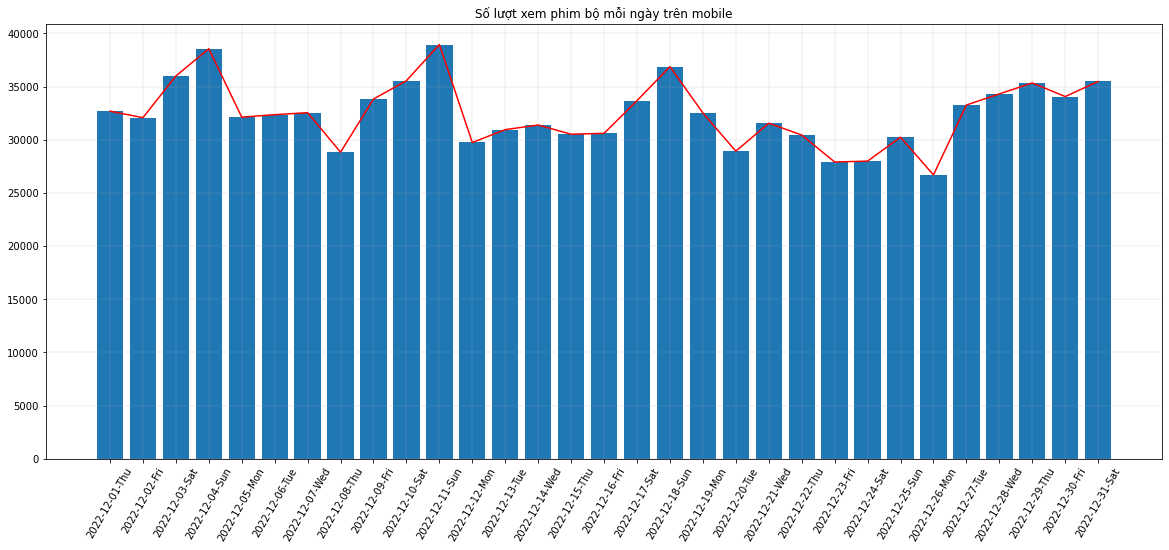

In [13]:
plt.figure(figsize=(20,8))
plt.bar(ls_days_of_week, ls_view_LogId111_each_day_mobile)
plt.plot(ls_days_of_week, ls_view_LogId111_each_day_mobile, color='red')
plt.xticks(rotation=60)
plt.grid(linewidth=0.2)
plt.title("Số lượt xem phim bộ mỗi ngày trên mobile")

Text(0.5, 1.0, 'Số lượt xem phim bộ mỗi ngày trên box')

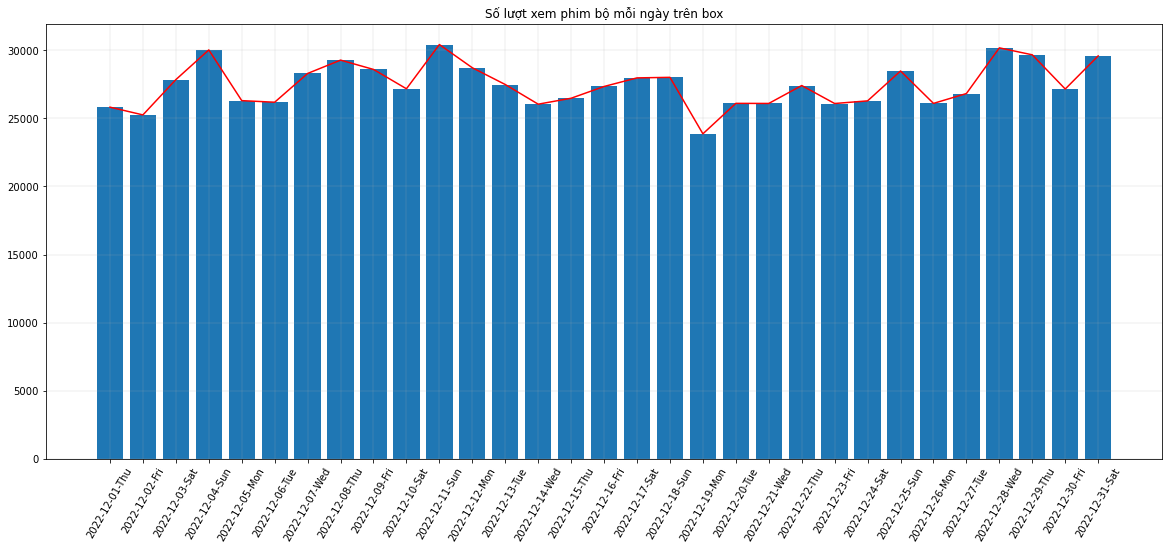

In [14]:
plt.figure(figsize=(20,8))
plt.bar(ls_days_of_week, ls_view_LogId111_each_day_box)
plt.plot(ls_days_of_week, ls_view_LogId111_each_day_box, color='red')
plt.xticks(rotation=60)
plt.grid(linewidth=0.2)
plt.title("Số lượt xem phim bộ mỗi ngày trên box")

Text(0.5, 1.0, 'Số lượt xem phim bộ mỗi ngày trên smarttv')

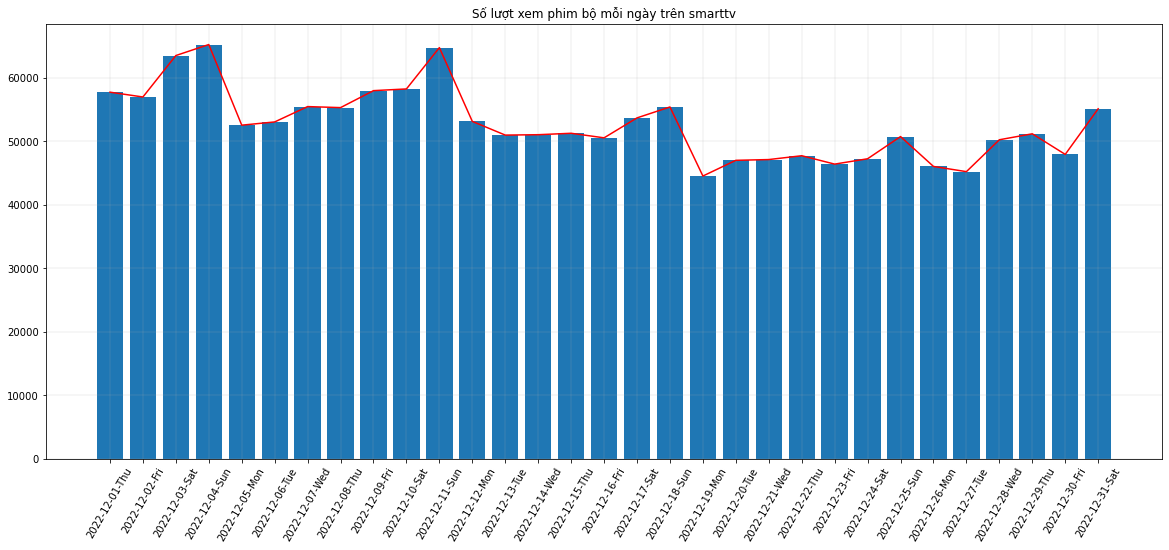

In [15]:
plt.figure(figsize=(20,8))
plt.bar(ls_days_of_week, ls_view_LogId111_each_day_smarttv)
plt.plot(ls_days_of_week, ls_view_LogId111_each_day_smarttv, color='red')
plt.xticks(rotation=60)
plt.grid(linewidth=0.2)
plt.title("Số lượt xem phim bộ mỗi ngày trên smarttv")

Text(0.5, 1.0, 'Số lượt xem phim bộ mỗi ngày trên từng thiết bị')

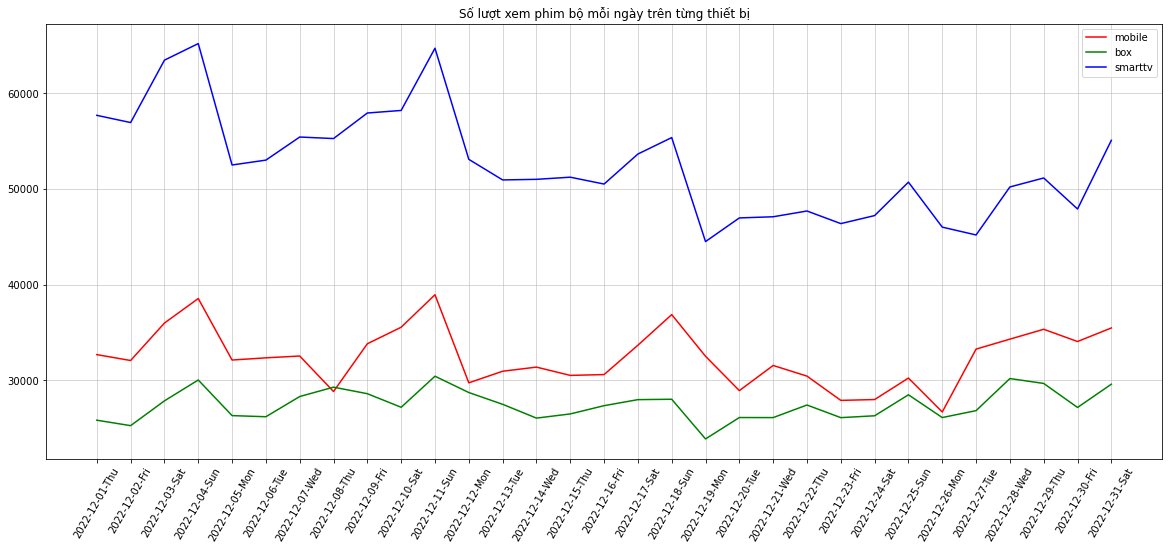

In [16]:
plt.figure(figsize=(20,8))
plt.plot(ls_days_of_week, ls_view_LogId111_each_day_mobile, color='red', label = "mobile")
plt.plot(ls_days_of_week, ls_view_LogId111_each_day_box, color='green', label = "box")
plt.plot(ls_days_of_week, ls_view_LogId111_each_day_smarttv, color='blue', label = "smarttv")

plt.xticks(rotation=60)
plt.grid(linewidth=0.5)
plt.legend()
plt.title("Số lượt xem phim bộ mỗi ngày trên từng thiết bị")


In [17]:
# Xem xét trong mỗi ngày, vào mỗi khung giờ có bao nhiêu lượt xem

def convert_to_2_chars(x, prefix = "0"):
    if len(str(x)) > 1:
        return str(x)
    else:
        return prefix + str(x)

# _mobile
dict_view_by_hour_each_day_mobile = dict()
for day in ls_day:
    sub_dict_mobile = {convert_to_2_chars(h):0 for h in range(0,24)}
    dict_view_by_hour_each_day_mobile.update({day:sub_dict_mobile})

for day, path_hdfs_1_day_mobile in tqdm(zip(ls_day, path_hdfs_mobile)):
    print("day:\t", day)
    df_mobile = spark.read.orc(path_hdfs_1_day_mobile)
    df_mobile = df_mobile.filter(lower(col('AppName')) == "phim bộ")
    for h in range(0,24):
        sub_df_mobile = df_mobile.filter(hour(col("playing_session")) == h)
        sub_df_count_mobile = sub_df_mobile.count()
        dict_view_by_hour_each_day_mobile[day][convert_to_2_chars(h)] += sub_df_count_mobile

# _box
dict_view_by_hour_each_day_box = dict()
for day in ls_day:
    sub_dict_box = {convert_to_2_chars(h):0 for h in range(0,24)}
    dict_view_by_hour_each_day_box.update({day:sub_dict_box})

for day, path_hdfs_1_day_box in tqdm(zip(ls_day, path_hdfs_box)):
    print("day:\t", day)
    df_box = spark.read.orc(path_hdfs_1_day_box)
    df_box = df_box.filter(lower(col('AppName')) == "phim bộ")
    for h in range(0,24):
        sub_df_box = df_box.filter(hour(col("playing_session")) == h)
        sub_df_count_box = sub_df_box.count()
        dict_view_by_hour_each_day_box[day][convert_to_2_chars(h)] += sub_df_count_box

# _smarttv
dict_view_by_hour_each_day_smarttv = dict()
for day in ls_day:
    sub_dict_smarttv = {convert_to_2_chars(h):0 for h in range(0,24)}
    dict_view_by_hour_each_day_smarttv.update({day:sub_dict_smarttv})

for day, path_hdfs_1_day_smarttv in tqdm(zip(ls_day, path_hdfs_smarttv)):
    print("day:\t", day)
    df_smarttv = spark.read.orc(path_hdfs_1_day_smarttv)
    df_smarttv = df_smarttv.filter(lower(col('AppName')) == "phim bộ")
    for h in range(0,24):
        sub_df_smarttv = df_smarttv.filter(hour(col("playing_session")) == h)
        sub_df_count_smarttv = sub_df_smarttv.count()
        dict_view_by_hour_each_day_smarttv[day][convert_to_2_chars(h)] += sub_df_count_smarttv

0it [00:00, ?it/s]

day:	 2022-12-01


1it [00:10, 10.17s/it]                                                          

day:	 2022-12-02


2it [00:20, 10.07s/it]

day:	 2022-12-03


3it [00:41, 15.05s/it]                                                          

day:	 2022-12-04


4it [00:53, 13.81s/it]                                                          

day:	 2022-12-05


5it [01:04, 12.81s/it]

day:	 2022-12-06


6it [01:14, 12.06s/it]

day:	 2022-12-07


7it [01:25, 11.62s/it]                                                          

day:	 2022-12-08


8it [01:36, 11.34s/it]

day:	 2022-12-09


9it [01:56, 14.12s/it]                                                          

day:	 2022-12-10


10it [02:06, 12.91s/it]

day:	 2022-12-11


11it [02:16, 12.08s/it]                                                         

day:	 2022-12-12


12it [02:26, 11.48s/it]

day:	 2022-12-13


13it [02:36, 11.00s/it]                                                         

day:	 2022-12-14


14it [02:56, 13.62s/it]                                                         

day:	 2022-12-15


15it [03:06, 12.48s/it]                                                         

day:	 2022-12-16


16it [03:15, 11.46s/it]

day:	 2022-12-17


17it [03:25, 11.11s/it]                                                         

day:	 2022-12-18


18it [03:34, 10.44s/it]

day:	 2022-12-19


19it [03:42,  9.83s/it]

day:	 2022-12-20


20it [03:51,  9.55s/it]                                                         

day:	 2022-12-21


21it [04:11, 12.61s/it]                                                         

day:	 2022-12-22


22it [04:21, 11.65s/it]

day:	 2022-12-23


23it [04:30, 10.85s/it]                                                         

day:	 2022-12-24


24it [04:39, 10.48s/it]

day:	 2022-12-25


25it [04:49, 10.31s/it]

day:	 2022-12-26


26it [05:00, 10.39s/it]                                                         

day:	 2022-12-27


27it [05:20, 13.42s/it]                                                         

day:	 2022-12-28


28it [05:31, 12.62s/it]

day:	 2022-12-29


29it [05:43, 12.34s/it]                                                         

day:	 2022-12-30


30it [05:54, 12.00s/it]

day:	 2022-12-31


31it [06:03, 11.73s/it]
0it [00:00, ?it/s]

day:	 2022-12-01


1it [00:10, 10.60s/it]                                                          

day:	 2022-12-02


2it [00:30, 16.07s/it]                                                          

day:	 2022-12-03


3it [00:41, 13.81s/it]

day:	 2022-12-04


4it [00:53, 12.96s/it]                                                          

day:	 2022-12-05


5it [01:03, 12.06s/it]

day:	 2022-12-06


6it [01:14, 11.76s/it]                                                          

day:	 2022-12-07


7it [01:34, 14.34s/it]                                                          

day:	 2022-12-08


8it [01:43, 12.74s/it]

day:	 2022-12-09


9it [01:54, 11.96s/it]                                                          

day:	 2022-12-10


10it [02:03, 11.24s/it]

day:	 2022-12-11


11it [02:13, 10.70s/it]

day:	 2022-12-12


12it [02:23, 10.45s/it]                                                         

day:	 2022-12-13


13it [02:31,  9.81s/it]

day:	 2022-12-14


14it [02:50, 12.63s/it]                                                         

day:	 2022-12-15


15it [03:00, 11.74s/it]                                                         

day:	 2022-12-16


16it [03:10, 11.26s/it]

day:	 2022-12-17


17it [03:20, 10.88s/it]

day:	 2022-12-18


18it [03:29, 10.37s/it]                                                         

day:	 2022-12-19


19it [03:39, 10.23s/it]

day:	 2022-12-20


20it [03:59, 13.18s/it]                                                         

day:	 2022-12-21


21it [04:10, 12.65s/it]                                                         

day:	 2022-12-22


22it [04:21, 11.96s/it]

day:	 2022-12-23


23it [04:31, 11.53s/it]

day:	 2022-12-24


24it [04:43, 11.71s/it]                                                         

day:	 2022-12-25


25it [05:04, 14.25s/it]                                                         

day:	 2022-12-26


26it [05:14, 13.07s/it]                                                         

day:	 2022-12-27


27it [05:24, 12.13s/it]

day:	 2022-12-28


28it [05:34, 11.40s/it]

day:	 2022-12-29


29it [05:44, 11.08s/it]                                                         

day:	 2022-12-30


30it [05:54, 10.76s/it]

day:	 2022-12-31


31it [06:14, 12.07s/it]                                                         
0it [00:00, ?it/s]

day:	 2022-12-01


1it [00:08,  8.69s/it]                                                          

day:	 2022-12-02


2it [00:17,  8.93s/it]

day:	 2022-12-03


3it [00:26,  8.79s/it]

day:	 2022-12-04


4it [00:35,  8.93s/it]                                                          

day:	 2022-12-05


5it [00:43,  8.70s/it]

day:	 2022-12-06


6it [00:52,  8.69s/it]

day:	 2022-12-07


7it [01:11, 12.05s/it]                                                          

day:	 2022-12-08


8it [01:20, 11.11s/it]

day:	 2022-12-09


9it [01:29, 10.57s/it]

day:	 2022-12-10


10it [01:39, 10.29s/it]                                                         

day:	 2022-12-11


11it [01:49, 10.06s/it]

day:	 2022-12-12


12it [01:58,  9.92s/it]

day:	 2022-12-13


13it [02:19, 13.17s/it]                                                         

day:	 2022-12-14


14it [02:30, 12.54s/it]

day:	 2022-12-15


15it [02:40, 11.92s/it]

day:	 2022-12-16


16it [02:51, 11.45s/it]                                                         

day:	 2022-12-17


17it [03:01, 10.99s/it]

day:	 2022-12-18


18it [03:11, 10.74s/it]                                                         

day:	 2022-12-19


19it [03:31, 13.53s/it]                                                         

day:	 2022-12-20


20it [03:40, 12.28s/it]

day:	 2022-12-21


21it [03:51, 11.73s/it]                                                         

day:	 2022-12-22


22it [04:02, 11.51s/it]

day:	 2022-12-23


23it [04:12, 11.22s/it]

day:	 2022-12-24


24it [04:24, 11.31s/it]                                                         

day:	 2022-12-25


25it [04:44, 14.02s/it]                                                         

day:	 2022-12-26


26it [04:55, 13.03s/it]

day:	 2022-12-27


27it [05:07, 12.60s/it]                                                         

day:	 2022-12-28


28it [05:17, 12.12s/it]

day:	 2022-12-29


29it [05:29, 11.84s/it]

day:	 2022-12-30


30it [05:50, 14.74s/it]                                                         

day:	 2022-12-31


31it [06:01, 11.65s/it]


In [18]:
write_json(r"{}/{}.json".format(config.folder_save_json, "dict_view_by_hour_each_day_mobile"), dict_view_by_hour_each_day_mobile)
write_json(r"{}/{}.json".format(config.folder_save_json, "dict_view_by_hour_each_day_box"), dict_view_by_hour_each_day_box)
write_json(r"{}/{}.json".format(config.folder_save_json, "dict_view_by_hour_each_day_smarttv"), dict_view_by_hour_each_day_smarttv)

In [19]:
print("dict_view_by_hour_each_day_mobile:\t", dict_view_by_hour_each_day_mobile)
print("dict_view_by_hour_each_day_box:\t", dict_view_by_hour_each_day_box)
print("dict_view_by_hour_each_day_smarttv:\t", dict_view_by_hour_each_day_smarttv)

dict_view_by_hour_each_day_mobile:	 {'2022-12-01': {'00': 1410, '01': 814, '02': 525, '03': 345, '04': 275, '05': 298, '06': 405, '07': 690, '08': 816, '09': 1130, '10': 1144, '11': 1493, '12': 1809, '13': 1497, '14': 1357, '15': 1275, '16': 966, '17': 1239, '18': 1648, '19': 2189, '20': 2690, '21': 3052, '22': 2965, '23': 2653}, '2022-12-02': {'00': 1378, '01': 777, '02': 624, '03': 420, '04': 265, '05': 263, '06': 369, '07': 596, '08': 833, '09': 1059, '10': 1171, '11': 1344, '12': 1681, '13': 1331, '14': 1294, '15': 1267, '16': 1114, '17': 1251, '18': 1611, '19': 2264, '20': 2562, '21': 2900, '22': 3045, '23': 2650}, '2022-12-03': {'00': 1348, '01': 817, '02': 542, '03': 428, '04': 237, '05': 346, '06': 346, '07': 488, '08': 851, '09': 1086, '10': 1250, '11': 1549, '12': 1869, '13': 1868, '14': 1645, '15': 1676, '16': 1457, '17': 1447, '18': 2026, '19': 2417, '20': 2997, '21': 3288, '22': 3194, '23': 2815}, '2022-12-04': {'00': 1561, '01': 913, '02': 615, '03': 474, '04': 322, '05':

In [20]:
# _mobile
list_view_by_hour_each_day_mobile = []
for day in dict_view_by_hour_each_day_mobile:
    list_view_by_hour_each_day_mobile.append(list(dict_view_by_hour_each_day_mobile[day].values()))

# _box
list_view_by_hour_each_day_box = []
for day in dict_view_by_hour_each_day_box:
    list_view_by_hour_each_day_box.append(list(dict_view_by_hour_each_day_box[day].values()))

# _smarttv
list_view_by_hour_each_day_smarttv = []
for day in dict_view_by_hour_each_day_smarttv:
    list_view_by_hour_each_day_smarttv.append(list(dict_view_by_hour_each_day_smarttv[day].values()))

In [21]:
write_json(r"{}/{}.json".format(config.folder_save_json, "list_view_by_hour_each_day_mobile"), list_view_by_hour_each_day_mobile)
write_json(r"{}/{}.json".format(config.folder_save_json, "list_view_by_hour_each_day_box"), list_view_by_hour_each_day_box)
write_json(r"{}/{}.json".format(config.folder_save_json, "list_view_by_hour_each_day_smarttv"), list_view_by_hour_each_day_smarttv)

In [22]:
def convert_num_to_K_or_M(list_num_2d, type_unit = "K"):
    new_list_num_2d = []
    for i in range(len(list_num_2d)):
        row = []
        for j in range(len(list_num_2d[0])):
            if type_unit == "K":
                row.append(str(list_num_2d[i][j]/1000) + type_unit)
            else:
                row.append(str(list_num_2d[i][j]/1000000) + type_unit)
        new_list_num_2d.append(row)
    return new_list_num_2d

In [23]:
convert_num_to_K_or_M(list_view_by_hour_each_day_mobile, type_unit = "K")

[['1.41K',
  '0.814K',
  '0.525K',
  '0.345K',
  '0.275K',
  '0.298K',
  '0.405K',
  '0.69K',
  '0.816K',
  '1.13K',
  '1.144K',
  '1.493K',
  '1.809K',
  '1.497K',
  '1.357K',
  '1.275K',
  '0.966K',
  '1.239K',
  '1.648K',
  '2.189K',
  '2.69K',
  '3.052K',
  '2.965K',
  '2.653K'],
 ['1.378K',
  '0.777K',
  '0.624K',
  '0.42K',
  '0.265K',
  '0.263K',
  '0.369K',
  '0.596K',
  '0.833K',
  '1.059K',
  '1.171K',
  '1.344K',
  '1.681K',
  '1.331K',
  '1.294K',
  '1.267K',
  '1.114K',
  '1.251K',
  '1.611K',
  '2.264K',
  '2.562K',
  '2.9K',
  '3.045K',
  '2.65K'],
 ['1.348K',
  '0.817K',
  '0.542K',
  '0.428K',
  '0.237K',
  '0.346K',
  '0.346K',
  '0.488K',
  '0.851K',
  '1.086K',
  '1.25K',
  '1.549K',
  '1.869K',
  '1.868K',
  '1.645K',
  '1.676K',
  '1.457K',
  '1.447K',
  '2.026K',
  '2.417K',
  '2.997K',
  '3.288K',
  '3.194K',
  '2.815K'],
 ['1.561K',
  '0.913K',
  '0.615K',
  '0.474K',
  '0.322K',
  '0.358K',
  '0.473K',
  '0.75K',
  '0.995K',
  '1.341K',
  '1.588K',
  '1.747K',

Text(0.5, 1.0, '2D Heat Map mobile')

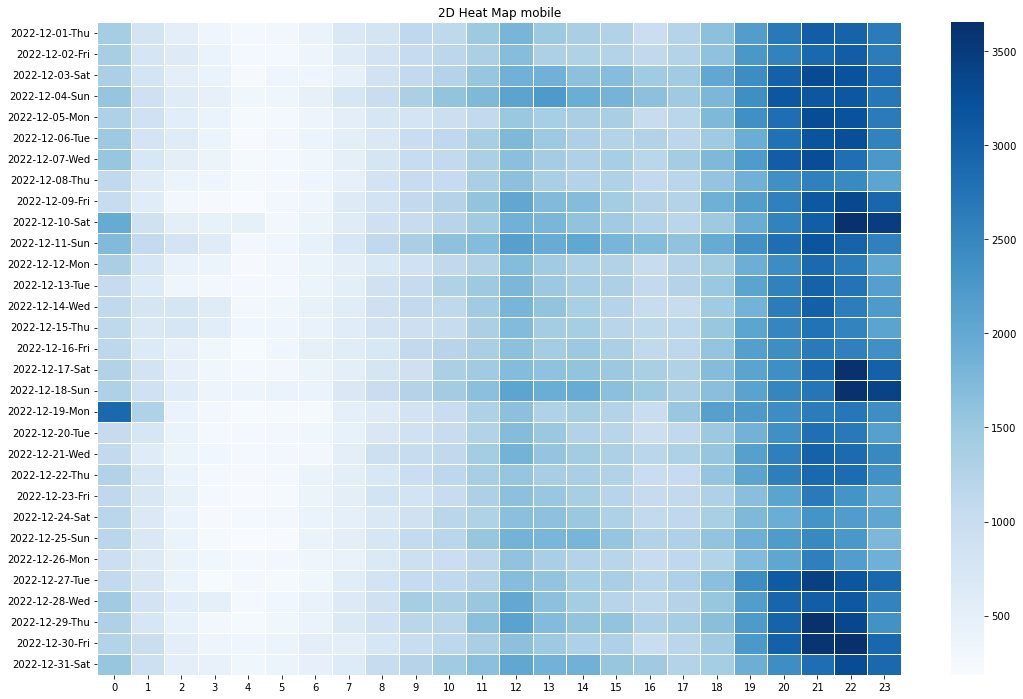

In [26]:
plt.figure(figsize=(18,12))
sns.heatmap(list_view_by_hour_each_day_mobile, 
            linewidth = 0.5, 
            cmap = 'Blues', 
            yticklabels = ls_days_of_week)
plt.title( "2D Heat Map mobile")

Text(0.5, 1.0, '2D Heat Map box')

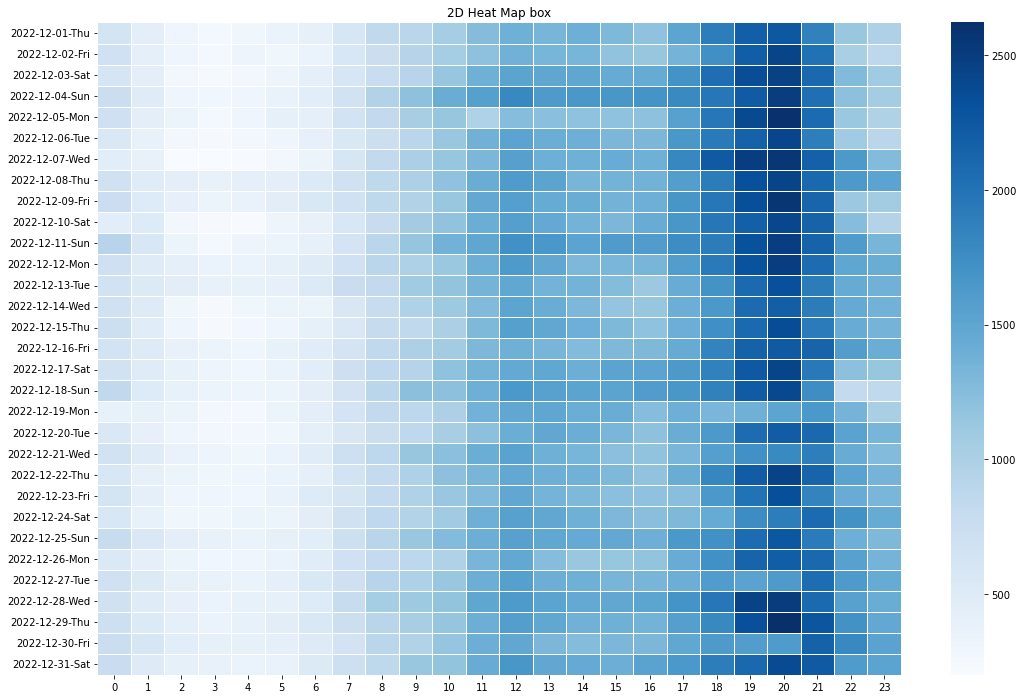

In [27]:
plt.figure(figsize=(18,12))
sns.heatmap(list_view_by_hour_each_day_box , linewidth = 0.5, cmap = 'Blues', yticklabels = ls_days_of_week)
plt.title( "2D Heat Map box")

Text(0.5, 1.0, '2D Heat Map smarttv')

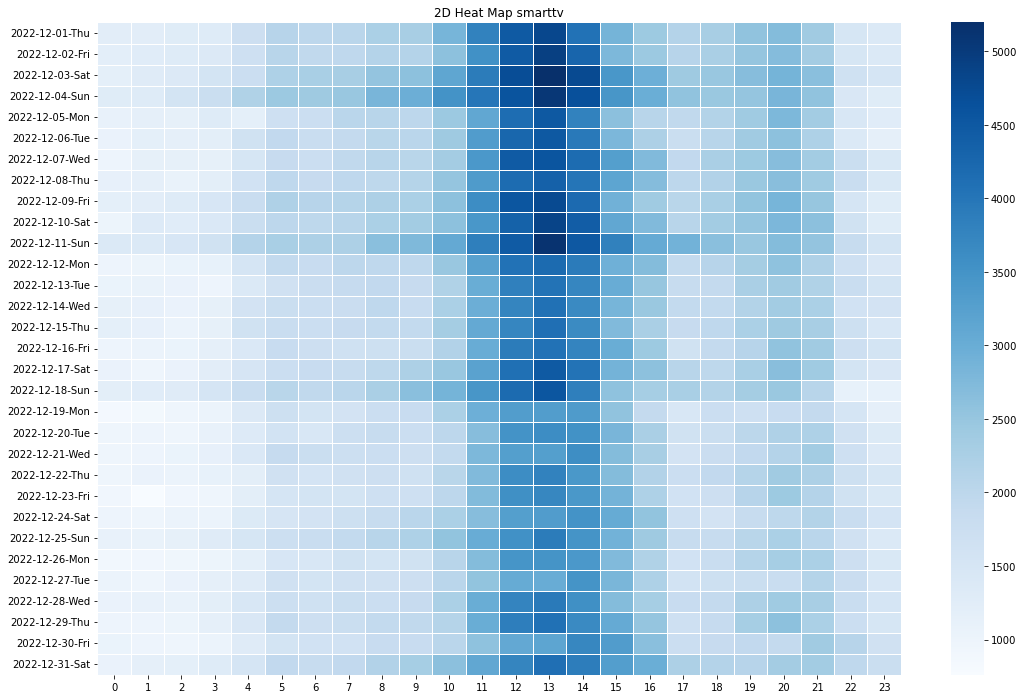

In [28]:
plt.figure(figsize=(18,12))
sns.heatmap(list_view_by_hour_each_day_smarttv , linewidth = 0.5, cmap = 'Blues', yticklabels = ls_days_of_week)
plt.title( "2D Heat Map smarttv")

In [29]:
list_view_by_hour_each_day_smarttv

[[1228,
  1233,
  1288,
  1320,
  1715,
  2093,
  2000,
  2028,
  2245,
  2300,
  2842,
  3795,
  4483,
  4811,
  4068,
  2866,
  2426,
  2124,
  2301,
  2575,
  2705,
  2385,
  1492,
  1387],
 [1197,
  1279,
  1327,
  1368,
  1694,
  2074,
  1948,
  1968,
  2124,
  2121,
  2608,
  3547,
  4463,
  4923,
  4291,
  2787,
  2450,
  2088,
  2259,
  2512,
  2688,
  2349,
  1496,
  1393],
 [1191,
  1305,
  1379,
  1560,
  1764,
  2201,
  2279,
  2294,
  2541,
  2613,
  3135,
  3898,
  4709,
  5197,
  4759,
  3433,
  2953,
  2418,
  2488,
  2674,
  2859,
  2633,
  1664,
  1533],
 [1291,
  1319,
  1565,
  1775,
  2165,
  2444,
  2420,
  2476,
  2839,
  2974,
  3499,
  3990,
  4574,
  5075,
  4659,
  3450,
  2986,
  2576,
  2466,
  2518,
  2837,
  2572,
  1452,
  1291],
 [1105,
  1163,
  1146,
  1330,
  1180,
  1680,
  1757,
  2026,
  2077,
  1997,
  2450,
  3108,
  4153,
  4488,
  3796,
  2617,
  2076,
  1947,
  2146,
  2392,
  2785,
  2369,
  1461,
  1268],
 [1069,
  1178,
  1164,
  1224,
  1

In [30]:
list(map(str, list(range(0,24))))

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23']

Text(0.5, 1.0, 'Tổng lượt xem phim bộ mỗi giờ trong 31 ngày trên mỗi thiết bị')

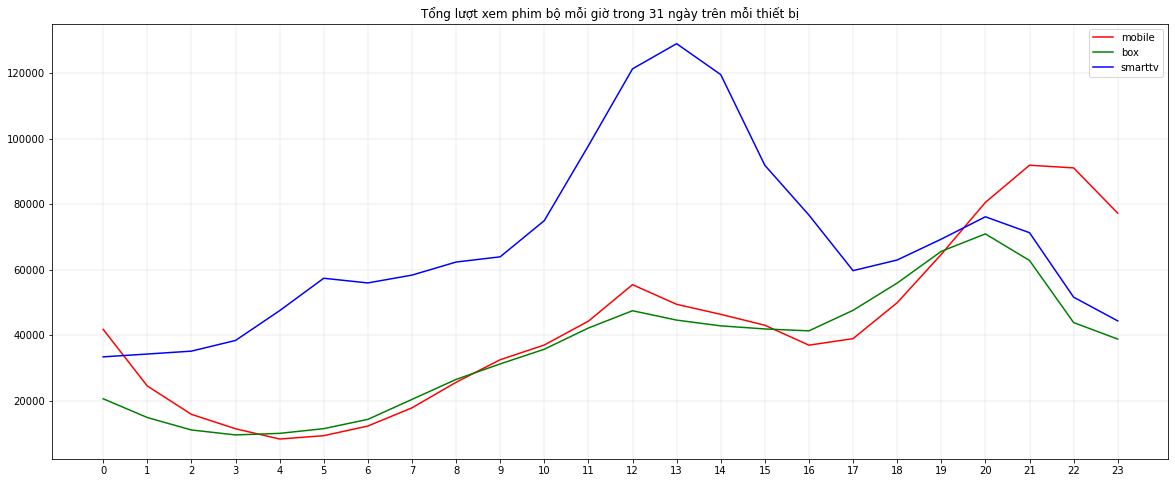

In [31]:
plt.figure(figsize=(20,8))
plt.plot(list(map(str, list(range(0,24)))), np.sum(list_view_by_hour_each_day_mobile, axis = 0), color='red', label = "mobile")
plt.plot(list(map(str, list(range(0,24)))), np.sum(list_view_by_hour_each_day_box, axis = 0), color='green', label = "box")
plt.plot(list(map(str, list(range(0,24)))), np.sum(list_view_by_hour_each_day_smarttv, axis = 0), color='blue', label = "smarttv")
# plt.xticks(rotation=60)
plt.grid(linewidth=0.2)
plt.legend()
plt.title("Tổng lượt xem phim bộ mỗi giờ trong 31 ngày trên mỗi thiết bị")

In [32]:
videos_ver2_collection = MongoClient(host="42.119.252.76:27017")["fteluv"]["videos_ver2"]

In [33]:
def get_title_title_vie(ls_idx):
    ls_ObjectIdx = [ObjectId(idx) for idx in ls_idx]
    res = list(videos_ver2_collection.find({"_id":{"$in": ls_ObjectIdx}}, {"title":1, "title_vie":1}))
    ls_title = [e["title"] for e in res]
    ls_title_vie = [e["title_vie"] for e in res]
    return {"title":ls_title, "title_vie":ls_title_vie}

In [36]:
df_mobile

DataFrame[user_id: string, playing_session: timestamp, AppId: string, AppName: string, ItemId: string, duration: int, end_time: timestamp]

In [37]:
# Lấy top 10 phim bộ được xem mỗi ngày trên mobile dựa theo đếm số lượt xem

total_view_LogId111_mobile = 0
ls_view_LogId111_each_day_mobile = []

dict_top_10_phimbo_mobile_each_day_by_count_duration = dict()

for day, path_hdfs_1_day_mobile in zip(ls_day, path_hdfs_mobile):
    print("day:\t", day)
    df_mobile = spark.read.orc(path_hdfs_1_day_mobile)
    
    df_mobile = df_mobile.filter(lower(col('AppName')) == "phim bộ")
    df_grb_mobile = df_mobile.groupby("ItemId").agg(ps_count('duration').alias("count_duration"), ps_sum('duration').alias("sum_duration"))
    df_grb_mobile = df_grb_mobile.sort(col('count_duration').desc())
    df_mobile = df_grb_mobile.limit(20).toPandas()

    df_mobile = df_mobile[df_mobile["ItemId"].apply(len) > 12]
    df_mobile = df_mobile.reset_index(drop=True)
    df_mobile = df_mobile.iloc[:10]

    dict_title_title_vie = get_title_title_vie(ls_idx = df_mobile["ItemId"])
    df_mobile["title"] = dict_title_title_vie["title"]
    df_mobile["title_vie"] = dict_title_title_vie["title_vie"]

    info = df_mobile.to_dict(orient='records')
    dict_top_10_phimbo_mobile_each_day_by_count_duration.update({day:info})

write_json(r"{}/{}.json".format(config.folder_save_json, "dict_top_10_phimbo_mobile_each_day_by_count_duration"), dict_top_10_phimbo_mobile_each_day_by_count_duration)

day:	 2022-12-01


day:	 2022-12-02


day:	 2022-12-03


day:	 2022-12-04


day:	 2022-12-05


day:	 2022-12-06


day:	 2022-12-07


day:	 2022-12-08


day:	 2022-12-09


day:	 2022-12-10


day:	 2022-12-11


day:	 2022-12-12


day:	 2022-12-13


day:	 2022-12-14


day:	 2022-12-15


day:	 2022-12-16


day:	 2022-12-17


day:	 2022-12-18


day:	 2022-12-19


day:	 2022-12-20


day:	 2022-12-21


day:	 2022-12-22


day:	 2022-12-23


day:	 2022-12-24


day:	 2022-12-25


day:	 2022-12-26


day:	 2022-12-27


day:	 2022-12-28


day:	 2022-12-29


day:	 2022-12-30


day:	 2022-12-31


In [38]:
# Lấy top 10 phim bộ được xem mỗi ngày trên box dựa theo đếm số lượt xem

total_view_LogId111_box = 0
ls_view_LogId111_each_day_box = []

dict_top_10_phimbo_box_each_day_by_count_duration = dict()

for day, path_hdfs_1_day_box in zip(ls_day, path_hdfs_box):
    print("day:\t", day)
    df_box = spark.read.orc(path_hdfs_1_day_box)
    
    df_box = df_box.filter(lower(col('AppName')) == "phim bộ")
    df_grb_box = df_box.groupby("ItemId").agg(ps_count('duration').alias("count_duration"), ps_sum('duration').alias("sum_duration"))
    df_grb_box = df_grb_box.sort(col('count_duration').desc())
    df_box = df_grb_box.limit(20).toPandas()

    df_box = df_box[df_box["ItemId"].apply(len) > 12]
    df_box = df_box.reset_index(drop=True)
    df_box = df_box.iloc[:10]

    dict_title_title_vie = get_title_title_vie(ls_idx = df_box["ItemId"])
    df_box["title"] = dict_title_title_vie["title"]
    df_box["title_vie"] = dict_title_title_vie["title_vie"]

    info = df_box.to_dict(orient='records')
    dict_top_10_phimbo_box_each_day_by_count_duration.update({day:info})

write_json(r"{}/{}.json".format(config.folder_save_json, "dict_top_10_phimbo_box_each_day_by_count_duration"), dict_top_10_phimbo_box_each_day_by_count_duration)

day:	 2022-12-01


day:	 2022-12-02


day:	 2022-12-03


day:	 2022-12-04


day:	 2022-12-05


day:	 2022-12-06


day:	 2022-12-07


day:	 2022-12-08


day:	 2022-12-09


day:	 2022-12-10


day:	 2022-12-11


day:	 2022-12-12


day:	 2022-12-13


day:	 2022-12-14


day:	 2022-12-15


day:	 2022-12-16


day:	 2022-12-17


day:	 2022-12-18


day:	 2022-12-19


day:	 2022-12-20


day:	 2022-12-21


day:	 2022-12-22


day:	 2022-12-23


day:	 2022-12-24


day:	 2022-12-25


day:	 2022-12-26


day:	 2022-12-27


day:	 2022-12-28


day:	 2022-12-29


day:	 2022-12-30


day:	 2022-12-31


In [39]:
# Lấy top 10 phim bộ được xem mỗi ngày trên smarttv dựa theo đếm số lượt xem

total_view_LogId111_smarttv = 0
ls_view_LogId111_each_day_smarttv = []

dict_top_10_phimbo_smarttv_each_day_by_count_duration = dict()

for day, path_hdfs_1_day_smarttv in zip(ls_day, path_hdfs_smarttv):
    print("day:\t", day)
    df_smarttv = spark.read.orc(path_hdfs_1_day_smarttv)
    
    df_smarttv = df_smarttv.filter(lower(col('AppName')) == "phim bộ")
    df_grb_smarttv = df_smarttv.groupby("ItemId").agg(ps_count('duration').alias("count_duration"), ps_sum('duration').alias("sum_duration"))
    df_grb_smarttv = df_grb_smarttv.sort(col('count_duration').desc())
    df_smarttv = df_grb_smarttv.limit(20).toPandas()

    df_smarttv = df_smarttv[df_smarttv["ItemId"].apply(len) > 12]
    df_smarttv = df_smarttv.reset_index(drop=True)
    df_smarttv = df_smarttv.iloc[:10]

    dict_title_title_vie = get_title_title_vie(ls_idx = df_smarttv["ItemId"])
    df_smarttv["title"] = dict_title_title_vie["title"]
    df_smarttv["title_vie"] = dict_title_title_vie["title_vie"]

    info = df_smarttv.to_dict(orient='records')
    dict_top_10_phimbo_smarttv_each_day_by_count_duration.update({day:info})

write_json(r"{}/{}.json".format(config.folder_save_json, "dict_top_10_phimbo_smarttv_each_day_by_count_duration"), dict_top_10_phimbo_smarttv_each_day_by_count_duration)

day:	 2022-12-01


day:	 2022-12-02


day:	 2022-12-03


day:	 2022-12-04


day:	 2022-12-05


day:	 2022-12-06


day:	 2022-12-07


day:	 2022-12-08


day:	 2022-12-09


day:	 2022-12-10


day:	 2022-12-11


day:	 2022-12-12


day:	 2022-12-13


day:	 2022-12-14


day:	 2022-12-15


day:	 2022-12-16


day:	 2022-12-17


day:	 2022-12-18


day:	 2022-12-19


day:	 2022-12-20


day:	 2022-12-21


day:	 2022-12-22


day:	 2022-12-23


day:	 2022-12-24


day:	 2022-12-25


day:	 2022-12-26


day:	 2022-12-27


2023-01-30 14:59:25,503 WARN datasources.SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


day:	 2022-12-28


day:	 2022-12-29


day:	 2022-12-30


day:	 2022-12-31


In [40]:
ls_top_10_phim_bo_all_device = []
for dict_device in dict_top_10_phimbo_mobile_each_day_by_count_duration, dict_top_10_phimbo_box_each_day_by_count_duration, dict_top_10_phimbo_smarttv_each_day_by_count_duration:
    for day in dict_device:
        info_1_day = dict_device[day]
        ls_title_vie = [e["title_vie"] for e in info_1_day]
        ls_top_10_phim_bo_all_device += ls_title_vie

ls_top_10_phim_bo_all_device = list(set(ls_top_10_phim_bo_all_device))

In [41]:
df_top_10_all_device = pd.DataFrame(data = np.zeros((len(ls_top_10_phim_bo_all_device), 3), dtype = int), columns = ["mobile", "box", "smarttv"], index = ls_top_10_phim_bo_all_device)

for dict_device, device in zip([dict_top_10_phimbo_mobile_each_day_by_count_duration, dict_top_10_phimbo_box_each_day_by_count_duration, dict_top_10_phimbo_smarttv_each_day_by_count_duration], device_ordering):
    for day in dict_device:
        info_1_day = dict_device[day]
        for item in info_1_day:  
            df_top_10_all_device.loc[item["title_vie"], device] += item["count_duration"]

In [42]:
df_top_10_all_device

,mobile,box,smarttv
Những Quý Cô Say Xỉn (Phần 2),0,682,1067
Dòng Máu Trăng Hoa,26890,15844,52978
Hướng Gió Mà Đi,3079,2113,4373
Vô Tình Nhặt Được Tổng Tài,4173,0,0
Cuộc Chiến Những Ngôi Sao,4720,0,0
Người Theo Đuổi Ánh Sáng,838,0,5957
Nghĩa Kỳ Quân Thân Yêu,1852,0,0
Rừng Hoa Rực Lửa,24572,987,2287
Ai Cũng Biết Em Yêu Anh,6752,1593,26330
Lấy Danh Nghĩa Người Nhà,0,1907,0


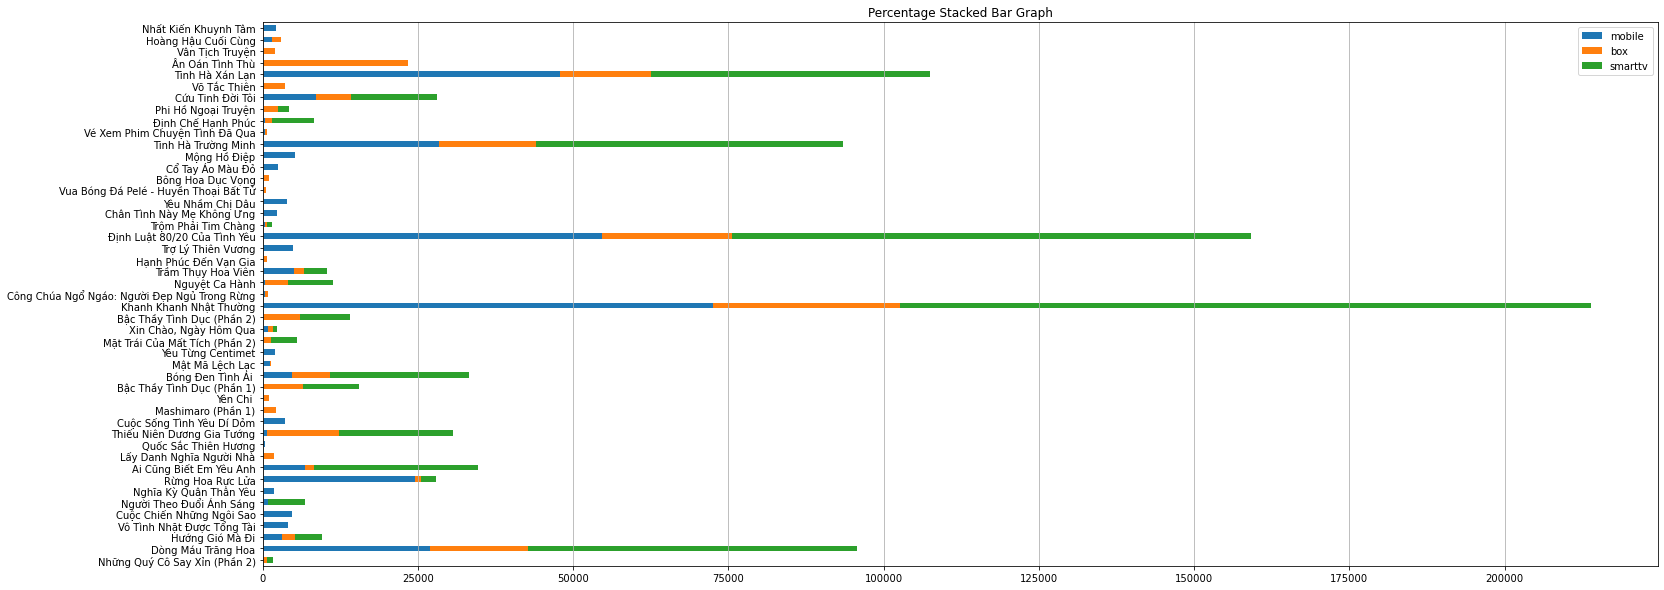

In [43]:
df_top_10_all_device.plot(kind = 'barh', 
                          stacked = True, 
                          title = 'Percentage Stacked Bar Graph', 
                          mark_right = True,
                          figsize=(25, 10))
plt.grid(axis='x')